In [1]:
import numpy as np 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.stats
import sklearn
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import plotly

ModuleNotFoundError: No module named 'plotly'

In [30]:
data_dir1 = "C:/Users/Savitha Srinivasan/UCSD assn/ECE 143/ECE-143-Project---Joke-recommendation-system/Dataset Version 1/jester-data-1.xls"
data_dir2 = "C:/Users/Savitha Srinivasan/UCSD assn/ECE 143/ECE-143-Project---Joke-recommendation-system/Dataset Version 1/jester-data-2.xls"
data_dir3 = "C:/Users/Savitha Srinivasan/UCSD assn/ECE 143/ECE-143-Project---Joke-recommendation-system/Dataset Version 1/jester-data-3.xls"
df1 = pd.read_excel(data_dir1, header=None)
df2 = pd.read_excel(data_dir2, header=None)
df3 = pd.read_excel(data_dir3, header=None)
df = df1.append(df2).append(df3)
# df = pd.DataFrame(pd.read_excel(data_dir))

In [31]:
df.index = range(df.shape[0])
df.index.name = "User ID"
col_names = ["joke"+str(i) for i in range(1, df.shape[1])]
df.columns = ["NumRated"] + col_names
df[df==99.0] = np.nan
df = df.loc[:, df.columns != "NumRated"]
df.head(6)
df_gauge = df[["joke7", "joke8", "joke13", "joke15", "joke16", "joke17", "joke18", "joke19"]] #[7, 8, 13, 15, 16, 17, 18, 19] 
df.head(6)

joke1  joke2  joke3  joke4  joke5  joke6  joke7  joke8  joke9  \
User ID                                                                  
0        -7.82   8.79  -9.66  -8.16  -7.52  -8.50  -9.85   4.17  -8.98   
1         4.08  -0.29   6.36   4.37  -2.38  -9.66  -0.73  -5.34   8.88   
2          NaN    NaN    NaN    NaN   9.03   9.27   9.03   9.27    NaN   
3          NaN   8.35    NaN    NaN   1.80   8.16  -2.82   6.21    NaN   
4         8.50   4.61  -4.17  -5.39   1.36   1.60   7.04   4.61  -0.44   
5        -6.17  -3.54   0.44  -8.50  -7.09  -4.32  -8.69  -0.87  -6.65   

         joke10  ...  joke91  joke92  joke93  joke94  joke95  joke96  joke97  \
User ID          ...                                                           
0         -4.76  ...    2.82     NaN     NaN     NaN     NaN     NaN   -5.63   
1          9.22  ...    2.82   -4.95   -0.29    7.86   -0.19   -2.14    3.06   
2           NaN  ...     NaN     NaN     NaN    9.08     NaN     NaN     NaN   
3          1.84  ...     NaN     NaN     NaN    0.53     NaN     NaN     NaN   
4          5.73  ...    5.19    5.58    4.27    5.19    5.73    1.55    3.11   
5         -1.80  ...   -3.54   -6.89   -0.68   -2.96   -2.18   -3.35    0.05   

         joke98  joke99  joke100  
User ID                           
0           NaN     NaN      NaN  
1          0.34   -4.32     1.07  
2           NaN     NaN      NaN  
3           NaN     NaN      NaN  
4          6.55    1.80     1.60  
5         -9.08   -5.05    -3.45  

[6 rows x 100 columns]

(73421,)
(73421,)


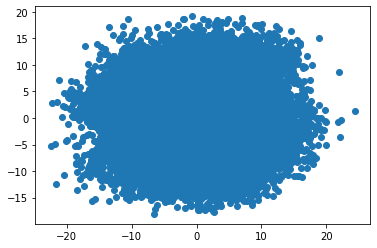

In [56]:
#normalization
def normalize_data(dataframe): 
    mean_data = dataframe.sum(axis=1, numeric_only=True)/dataframe.count(1)
    mean_sub = dataframe.subtract(mean_data, axis='rows')
    mean_pow = mean_sub.pow(2, axis='columns')
    var = mean_pow.sum(axis=1, numeric_only=True)/(mean_pow.count(1)-1)
    print(var.shape)
    # return mean_sub.divide(var, axis='rows')
    return mean_sub
normalized_df = normalize_data(df)
normalized_df_gauge = normalize_data(df_gauge)
A = normalized_df_gauge.fillna(0.0).values
pca = PCA(n_components=2)
reduced_A = pca.fit_transform(A)
# pca.explained_variance_ratio_
plt.scatter(reduced_A[:,0], reduced_A[:,1])
plt.show()

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Mean rating per user')]

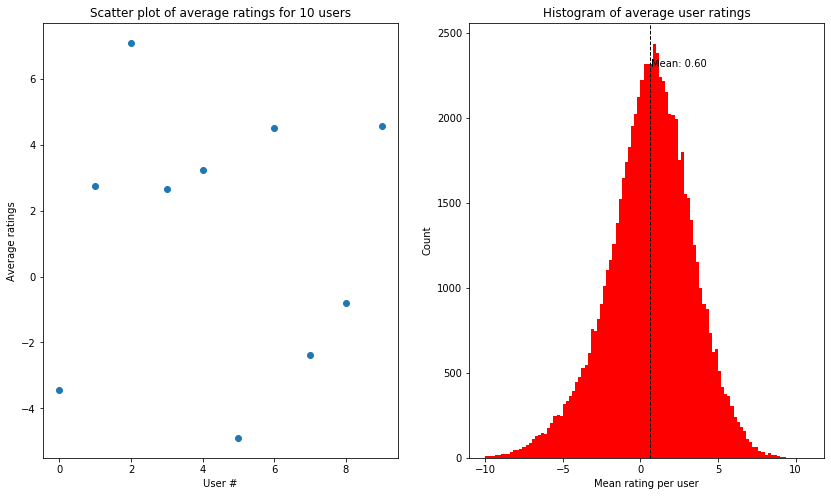

In [37]:
avg_joke_rating = np.nanmean(df,axis=0)
each_user_avg = np.nanmean(df,axis=1)
fig=plt.figure(figsize=(14,8)) 
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.hist(each_user_avg, np.arange(-10,11,0.2), color = "red")
ax1.scatter(np.arange(0,10),each_user_avg[:10])
ax1.set_title('Scatter plot of average ratings for 10 users')
ax1.set(xlabel='User #', ylabel='Average ratings')
ax2.set_title('Histogram of average user ratings')
ax2.axvline(each_user_avg.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
ax2.text(each_user_avg.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(each_user_avg.mean()))
ax2.set(xlabel='Mean rating per user', ylabel='Count')

In [38]:
#similarity computation
import scipy
def pearson(new_user, dataframe): 
    d1 = np.nansum(np.square(new_user)) 
    d2 = np.nansum(np.square(dataframe),axis=1)
    sim = np.nan_to_num(np.nansum(dataframe*new_user, axis=1)/np.sqrt(d1*d2))
    most_similar = np.sort(sim)[-20:]
    most_similar_idx = np.argsort(sim)[-20:]
    return (most_similar, most_similar_idx)

def cosine_similarity(new_user,dataframe): 
    numerator = np.nansum(dataframe * new_user, axis=1)
    norm_user = np.sqrt(np.nansum(np.power(new_user, 2)))
    norm_df = np.sqrt(np.nansum(np.power(dataframe, 2), axis=1))
    sim = numerator / (norm_user * norm_df)
    sim = np.nan_to_num(sim)
    most_similar = np.sort(sim)[-20:]
    most_similar_idx = np.argsort(sim)[-20:]
    return (most_similar, most_similar_idx)

def get_top_smilar_jokes(most_similar, top_user_matrix): 
    scores_matrix = top_user_matrix.copy() 
    top_jokes = np.nansum(top_user_matrix.T * most_similar, axis=1)/np.sum(most_similar)
    top_5 = np.argsort(top_jokes)[-5:]
    return top_5 



In [39]:
# gauge_set = [7, 8, 13, 15, 16, 17, 18, 19] #using PCA 
gauge_set = list(range(100))
new_user = normalized_df.iloc[0].copy() 
new_user[:] = np.nan
new_user.iloc[gauge_set] = normalized_df.iloc[0,gauge_set]
most_similar, most_similar_idx = pearson(new_user,normalized_df)
top_user_matrix = normalized_df.iloc[most_similar_idx].copy()
top_5 = get_top_smilar_jokes(most_similar, top_user_matrix)
print("Top 5 recommended jokes:", top_5)
print("Actual rankings given by the user:\n{}".format(df.iloc[0, list(top_5)]))

Top 5 recommended jokes: [68 26 67 53 28]
Actual rankings given by the user:
joke69    5.68
joke27    7.82
joke68    8.30
joke54    8.30
joke29    9.13
Name: 0, dtype: float64
